# OLS Regression

In [223]:
import kagglehub

import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics import root_mean_squared_error, r2_score
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [224]:
warnings.simplefilter("ignore")

In [ ]:
path = kagglehub.dataset_download("budincsevity/szeged-weather")
file_name = "weatherHistory.csv"
df = pd.read_csv(path + "\\" + file_name)

# view
print(df.shape)
display(df.head())
display(df.describe())

# drop columns
df = df.drop(columns=["Formatted Date", "Daily Summary", "Loud Cover", "Apparent Temperature (C)"])

# rename columns
df.columns = ['Summary', 'PrecipType', 'Temp', 'Humidity', 'WindSpeed', 'WindBearing', 'Visibility', 'Pressure']

# convert summary to dummy
mlb = MultiLabelBinarizer()
SummarySplit = df["Summary"].str.lower().str.split(' and ')
dummies_summary = pd.DataFrame(mlb.fit_transform(SummarySplit), columns=mlb.classes_, index=df.index).iloc[:,1:].reset_index(drop=True)
df = df.drop(columns=["Summary"])

# convert precip type to dummy 
dummies_precip_type = pd.get_dummies(df["PrecipType"], drop_first=True).astype(int).reset_index(drop=True)
df = df.drop(columns=["PrecipType"])

# join to full dataframe
df = pd.concat([df, dummies_summary, dummies_precip_type], axis=1)
df

(96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


,Temp,Humidity,WindSpeed,WindBearing,Visibility,Pressure,clear,dangerously windy,drizzle,dry,foggy,humid,light rain,mostly cloudy,overcast,partly cloudy,rain,windy,snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,0,0,0,0,0,1,0,0,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,0,0,0,1,0,0,0,0,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,0,0,0,0,0,1,0,0,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0,0,0,0,0,0,0,0,0,1,0,0,0
96449,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0,0,0,0,0,0,0,0,0,1,0,0,0
96450,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0,0,0,0,0,0,0,0,0,1,0,0,0
96451,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0,0,0,0,0,0,0,0,0,1,0,0,0


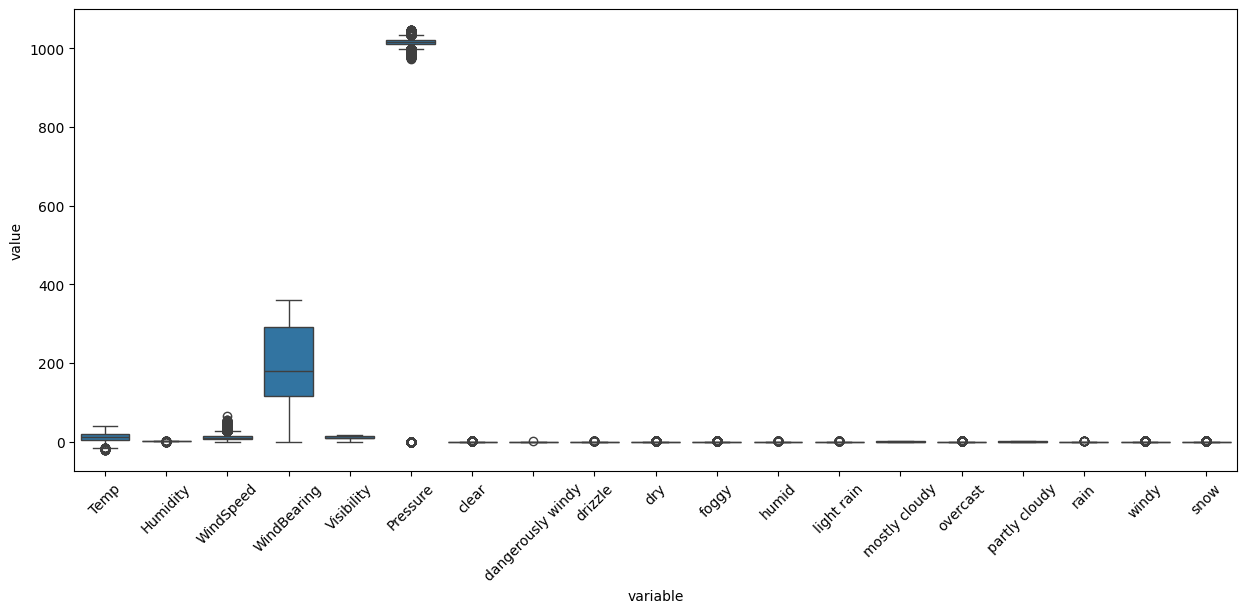

In [ ]:
plt.figure(figsize=(15, 6))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplots.set_xticklabels(boxplots.get_xticklabels(), rotation=45)
plt.show()

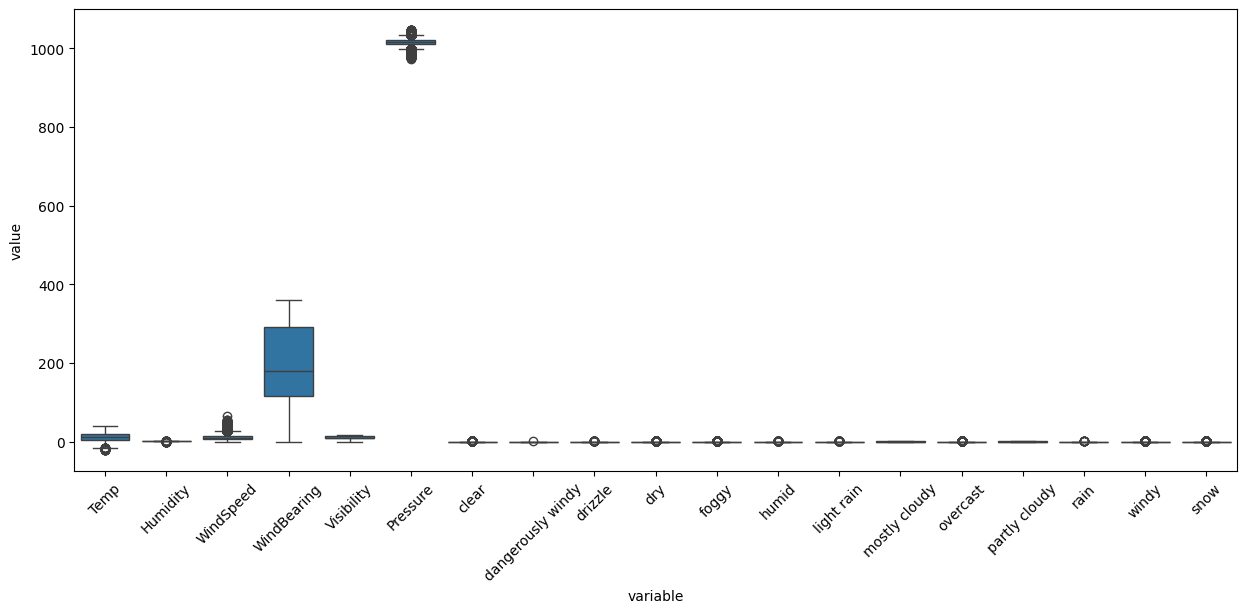

In [ ]:
df = df[df["Pressure"]!=0]
plt.figure(figsize=(15, 6))
boxplots = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplots.set_xticklabels(boxplots.get_xticklabels(), rotation=45)
plt.show()

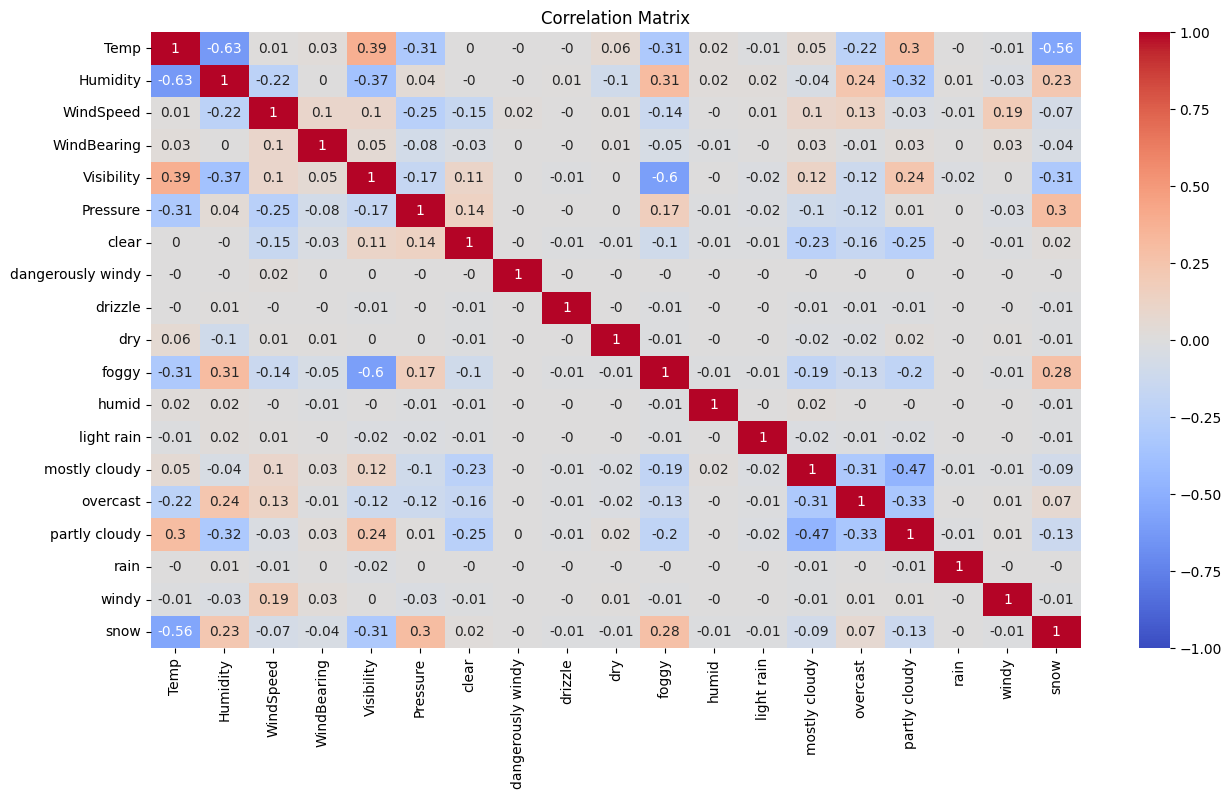

In [ ]:
corr_matrix = df.corr().round(decimals=2)
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# split datasets in y (response) and X (predictors) 
# for train, test, and validation sets

response = "Temp"

y = df[[response]]
X = df.drop(columns=[response])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)
X_test = sm.add_constant(X_test)

In [ ]:
# fit the model
model = sm.OLS(y_train, X_train).fit()

# make predictions
y_pred = model.predict(X_val)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model.summary())

RMSE = 5.5722315666186635
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     5998.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57080   BIC:                         3.594e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const       

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["rain"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_val_reduced = X_val.drop(columns=drop_cols)

# fit the model
model2 = sm.OLS(y_train, X_train_reduced).fit()

# make predictions
y_pred = model2.predict(X_val_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model2.summary())

RMSE = 5.572212627968851
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     6351.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57081   BIC:                         3.594e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["rain", "dry"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_val_reduced = X_val.drop(columns=drop_cols)

# fit the model
model3 = sm.OLS(y_train, X_train_reduced).fit()

# make predictions
y_pred = model3.predict(X_val_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model3.summary())

RMSE = 5.572224448491456
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     6748.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57082   BIC:                         3.593e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["rain", "dry", "drizzle"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_val_reduced = X_val.drop(columns=drop_cols)

# fit the model
model4 = sm.OLS(y_train, X_train_reduced).fit()

# make predictions
y_pred = model4.predict(X_val_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model4.summary())

RMSE = 5.572255731952836
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     7198.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57083   BIC:                         3.593e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["rain", "dry", "drizzle", "light rain"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_val_reduced = X_val.drop(columns=drop_cols)

# fit the model
model5 = sm.OLS(y_train, X_train_reduced).fit()

# make predictions
y_pred = model5.predict(X_val_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model5.summary())

RMSE = 5.572350213523133
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     7712.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57084   BIC:                         3.593e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["rain", "dry", "drizzle", "light rain", "partly cloudy"]
X_train_reduced = X_train.drop(columns=drop_cols)
X_val_reduced = X_val.drop(columns=drop_cols)

# fit the model
model6 = sm.OLS(y_train, X_train_reduced).fit()

# make predictions
y_pred = model6.predict(X_val_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("RMSE =", rmse)
print(model6.summary())

RMSE = 5.572317717382579
                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     8305.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:14:17   Log-Likelihood:            -1.7958e+05
No. Observations:               57099   AIC:                         3.592e+05
Df Residuals:                   57085   BIC:                         3.593e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

# Normalise the data

In [ ]:
#normalise data so it's all on the same scale
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,1:]), columns=X_train.columns[1:])
y_train_norm = scaler.fit_transform(y_train)
# train_norm = X_train_norm
# train_norm["Response"] = y_train_norm

X_test_norm = pd.DataFrame(scaler.fit_transform(X_test.iloc[:,1:]), columns=X_test.columns[1:])
y_test_norm = scaler.fit_transform(y_test)

X_val_norm = pd.DataFrame(scaler.fit_transform(X_val.iloc[:,1:]), columns=X_val.columns[1:])
y_val_norm = scaler.fit_transform(y_val)

In [ ]:
# fit the model
model_norm = sm.OLS(y_train_norm, X_train_norm).fit()

# make predictions
y_pred_norm = model_norm.predict(X_val_norm)

# performance metrics
rmse = root_mean_squared_error(y_val_norm, y_pred_norm)
r2 = r2_score(y_val_norm, y_pred_norm)
print("RMSE =", rmse)
print(model_norm.summary())

RMSE = 0.09891876606183177
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.108e+05
Date:                Tue, 25 Mar 2025   Prob (F-statistic):                        0.00
Time:                        17:17:03   Log-Likelihood:                          52582.
No. Observations:               57099   AIC:                                 -1.051e+05
Df Residuals:                   57081   BIC:                                 -1.050e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
-------

In [ ]:
# features to drop - highest insignificance first
drop_cols = ["windy"]
X_train_norm_reduced = X_train_norm.drop(columns=drop_cols)
X_val_norm_reduced = X_val_norm.drop(columns=drop_cols)

# fit the model
model_norm2 = sm.OLS(y_train_norm, X_train_norm_reduced).fit()

# make predictions
y_pred_norm = model_norm2.predict(X_val_norm_reduced)

# performance metrics
rmse = root_mean_squared_error(y_val_norm, y_pred_norm)
r2 = r2_score(y_val_norm, y_pred_norm)
print("RMSE =", rmse)
print(model_norm2.summary())

RMSE = 0.09891852400956194
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.174e+05
Date:                Tue, 25 Mar 2025   Prob (F-statistic):                        0.00
Time:                        17:17:04   Log-Likelihood:                          52581.
No. Observations:               57099   AIC:                                 -1.051e+05
Df Residuals:                   57082   BIC:                                 -1.050e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
-------

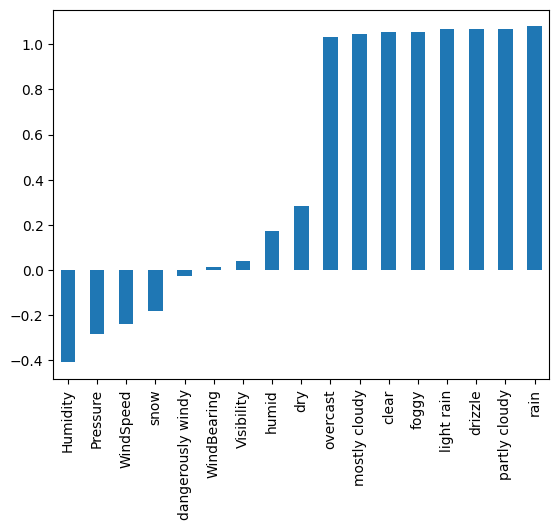

In [ ]:
coefficients = model_norm2.params.sort_values()
coefficients.plot(kind="bar")
plt.show()